In [1]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import os
import sys
import csv
import talib
from   scipy.stats       import norm
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import mplfinance        as mpf

In [2]:
df_ = pd.read_csv("./data/USDJPY.csv", parse_dates=True, index_col="datetime")

In [3]:
timeframe_by_minute = 30

In [4]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2000-01-02 23:00:00+00:00,102.140,102.260,102.120,102.260,36
2000-01-02 23:30:00+00:00,102.150,102.200,102.120,102.200,68
2000-01-03 00:00:00+00:00,102.200,102.220,102.100,102.150,44
2000-01-03 00:30:00+00:00,102.120,102.130,102.030,102.050,36
2000-01-03 01:00:00+00:00,102.070,102.070,101.900,101.950,42
...,...,...,...,...,...
2023-08-10 01:00:00+00:00,143.806,143.837,143.731,143.808,1193
2023-08-10 01:30:00+00:00,143.810,143.841,143.756,143.772,1223
2023-08-10 02:00:00+00:00,143.773,143.820,143.745,143.751,910


mean    : 50.49047641897014
std.dev : 11.98708188994713
sigma lower : 26.5
sigma upper : 74.5


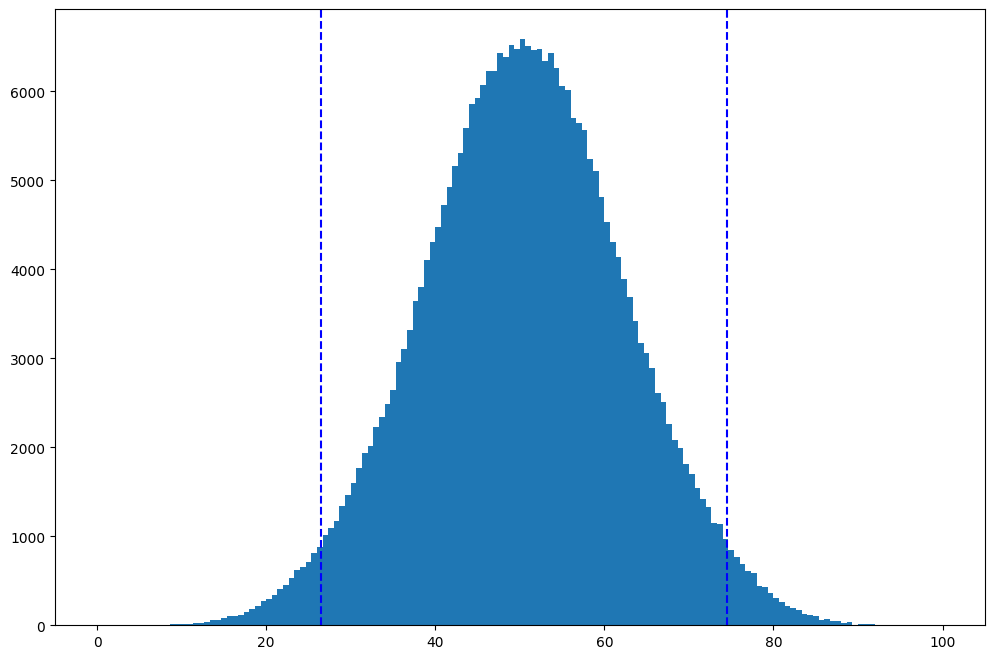

In [5]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [6]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
 1.0    2401
-1.0    2179
Name: count, dtype: int64

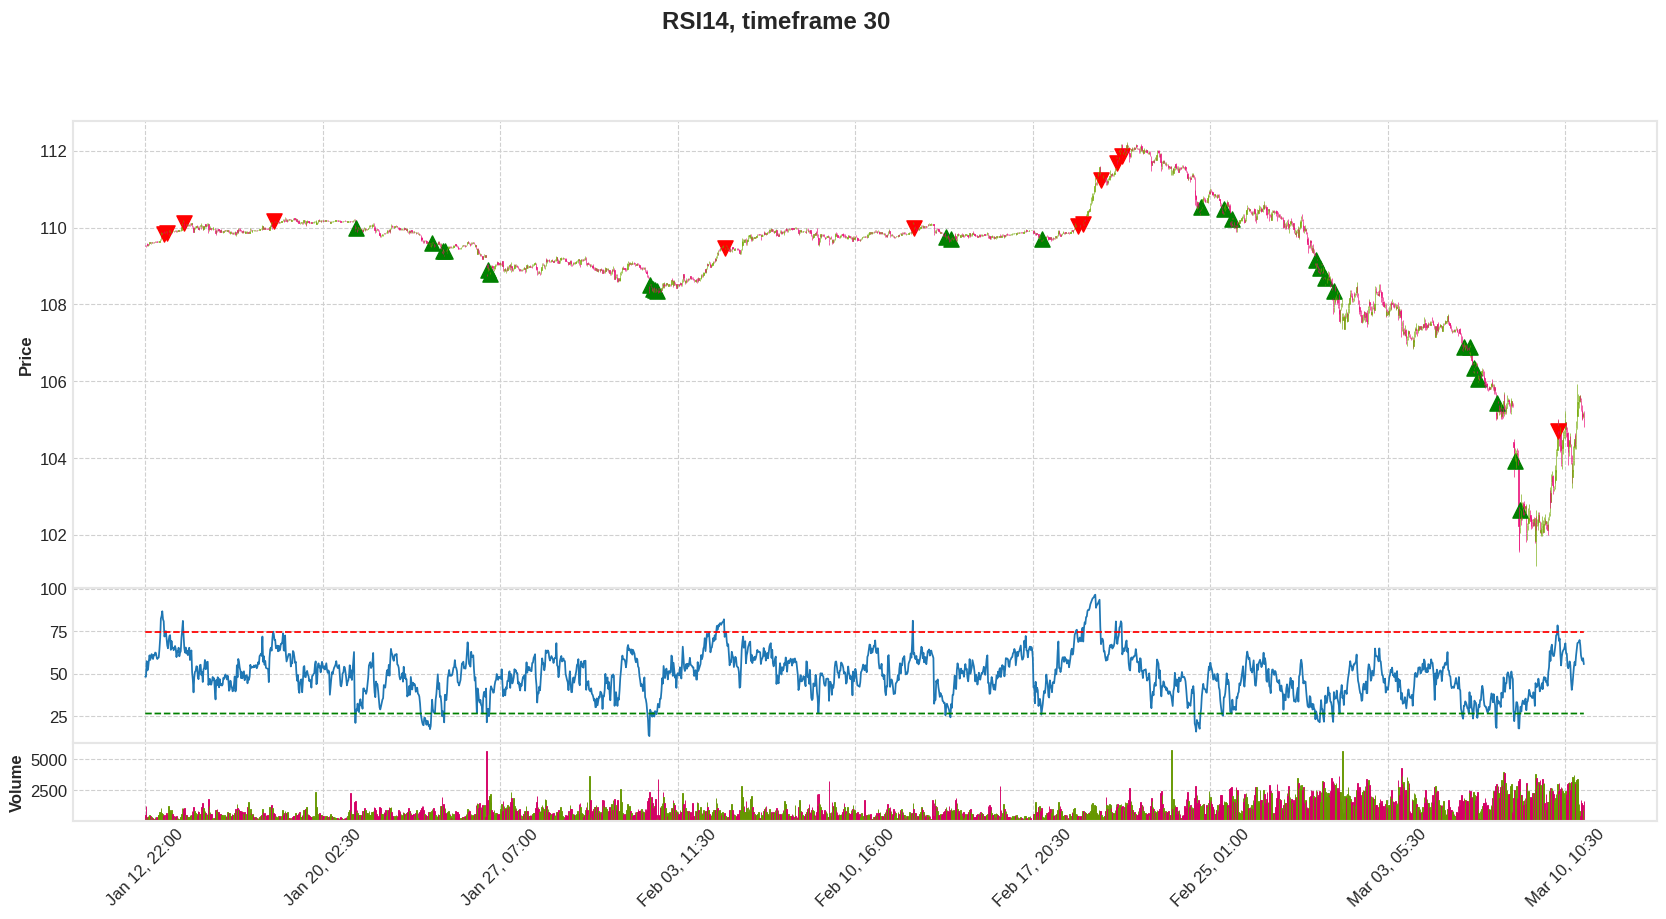

In [7]:
plot_df = df["2020-01-12 10:00:00":"2020-03-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=120, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=120, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [8]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

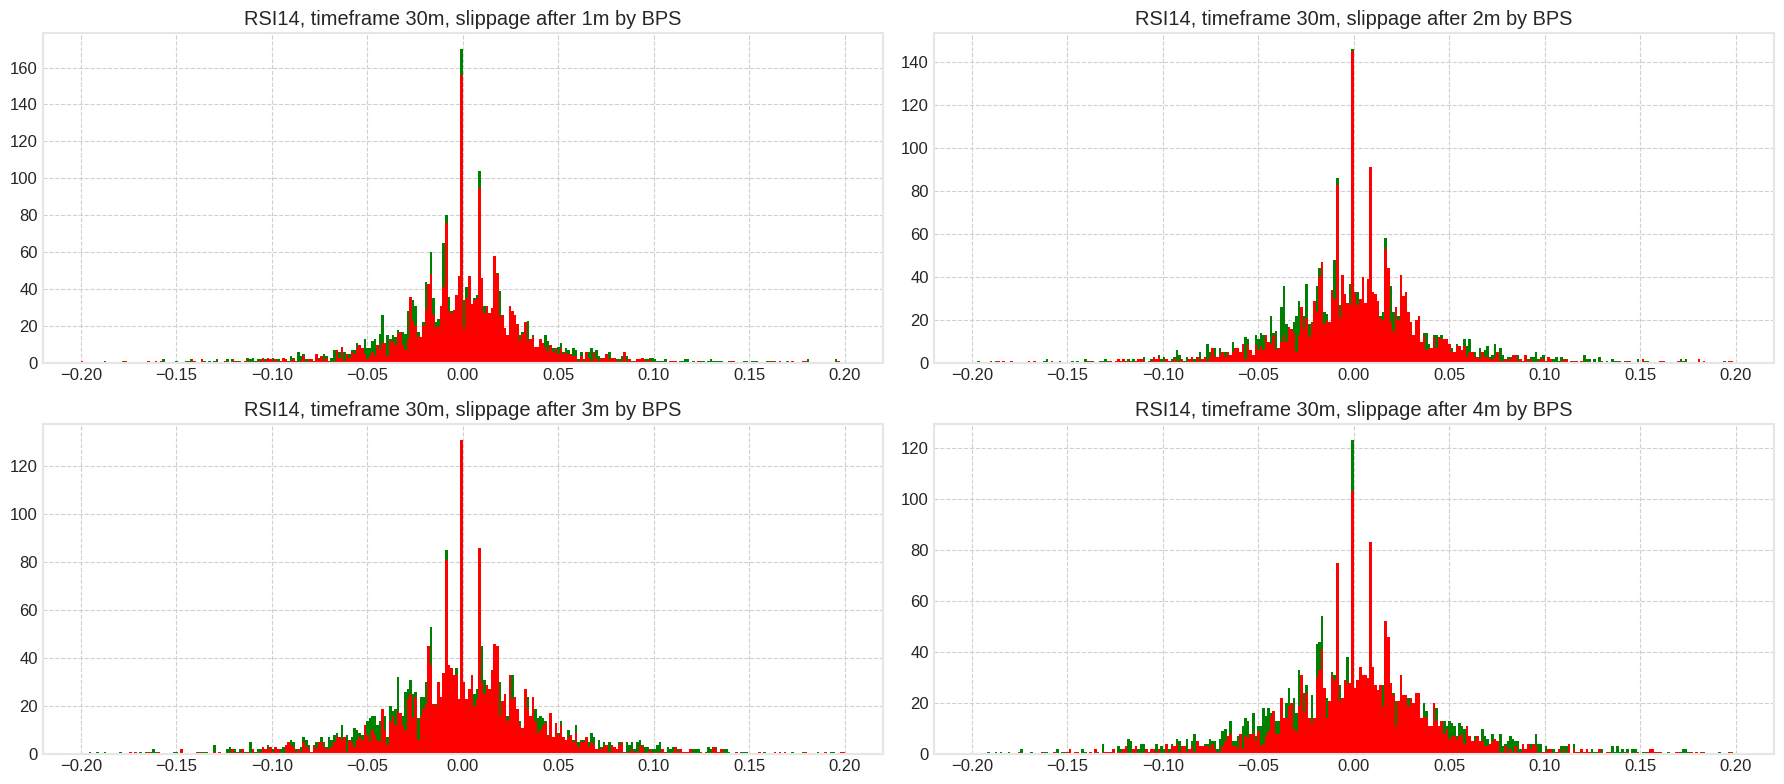

In [11]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-0.2, 0.2)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();

In [12]:
timeframe_by_hours  = 1
timeframe_by_minute = timeframe_by_hours*60

In [13]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2000-01-02 23:00:00+00:00,102.140,102.260,102.120,102.200,104
2000-01-03 00:00:00+00:00,102.200,102.220,102.030,102.050,80
2000-01-03 01:00:00+00:00,102.070,102.070,101.900,101.990,90
2000-01-03 02:00:00+00:00,102.000,102.030,101.840,101.920,138
2000-01-03 03:00:00+00:00,101.920,102.000,101.880,101.930,85
...,...,...,...,...,...
2023-08-09 23:00:00+00:00,143.664,143.756,143.631,143.716,980
2023-08-10 00:00:00+00:00,143.716,143.885,143.683,143.805,2879
2023-08-10 01:00:00+00:00,143.806,143.841,143.731,143.772,2416


mean    : 50.59424251169083
std.dev : 12.37742846819686
sigma lower : 25.8
sigma upper : 75.3


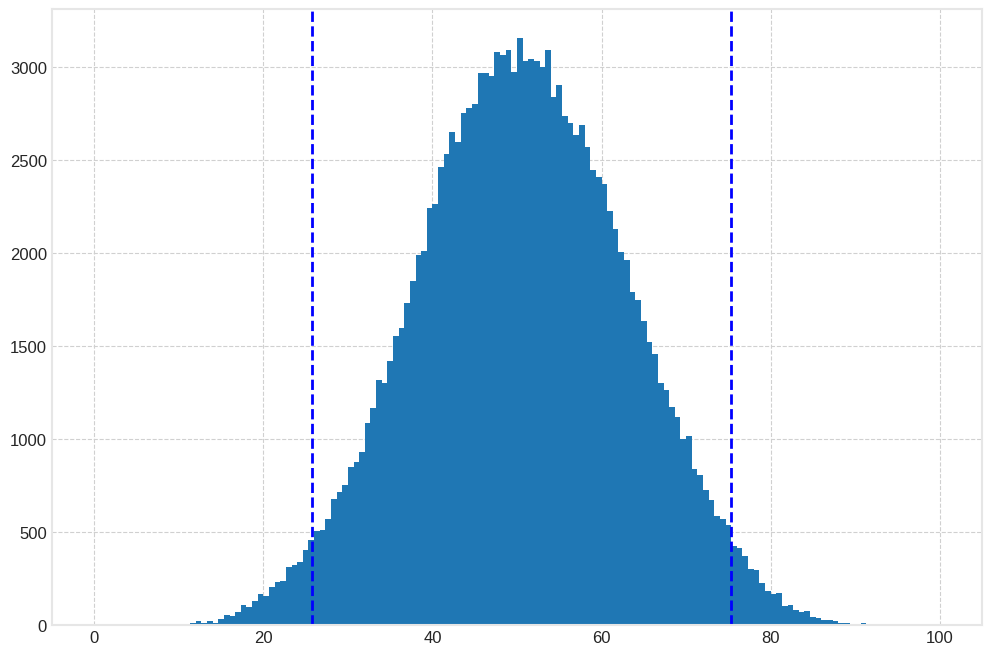

In [14]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [15]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
 1.0    1161
-1.0    1043
Name: count, dtype: int64

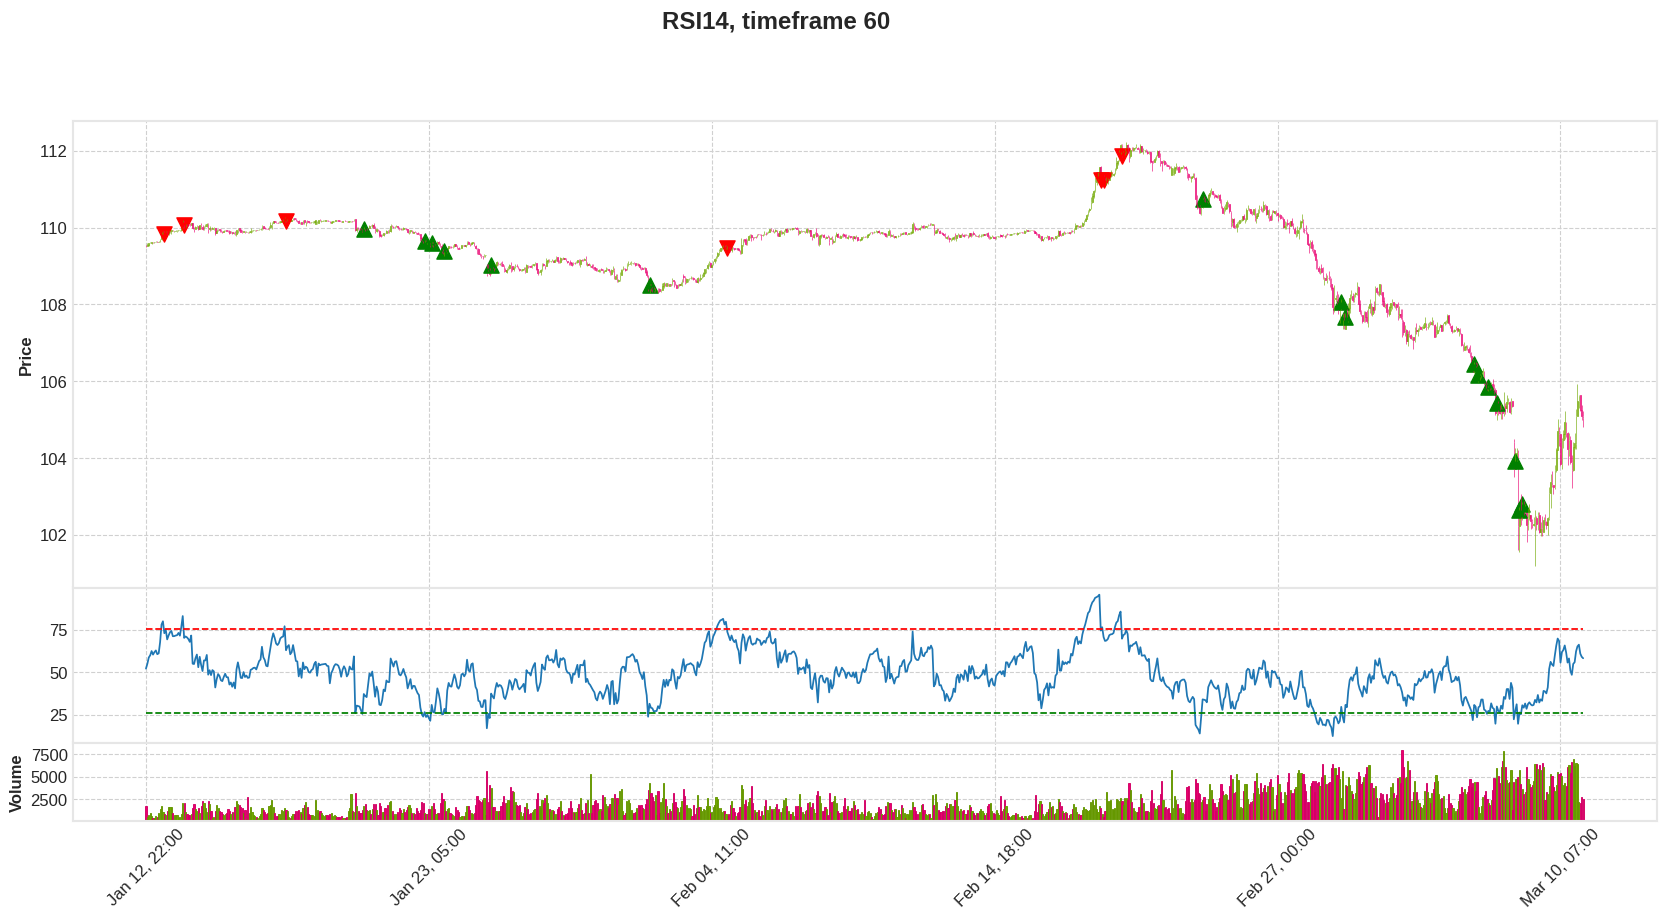

In [16]:
plot_df = df["2020-01-12 10:00:00":"2020-03-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=120, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=120, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [17]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

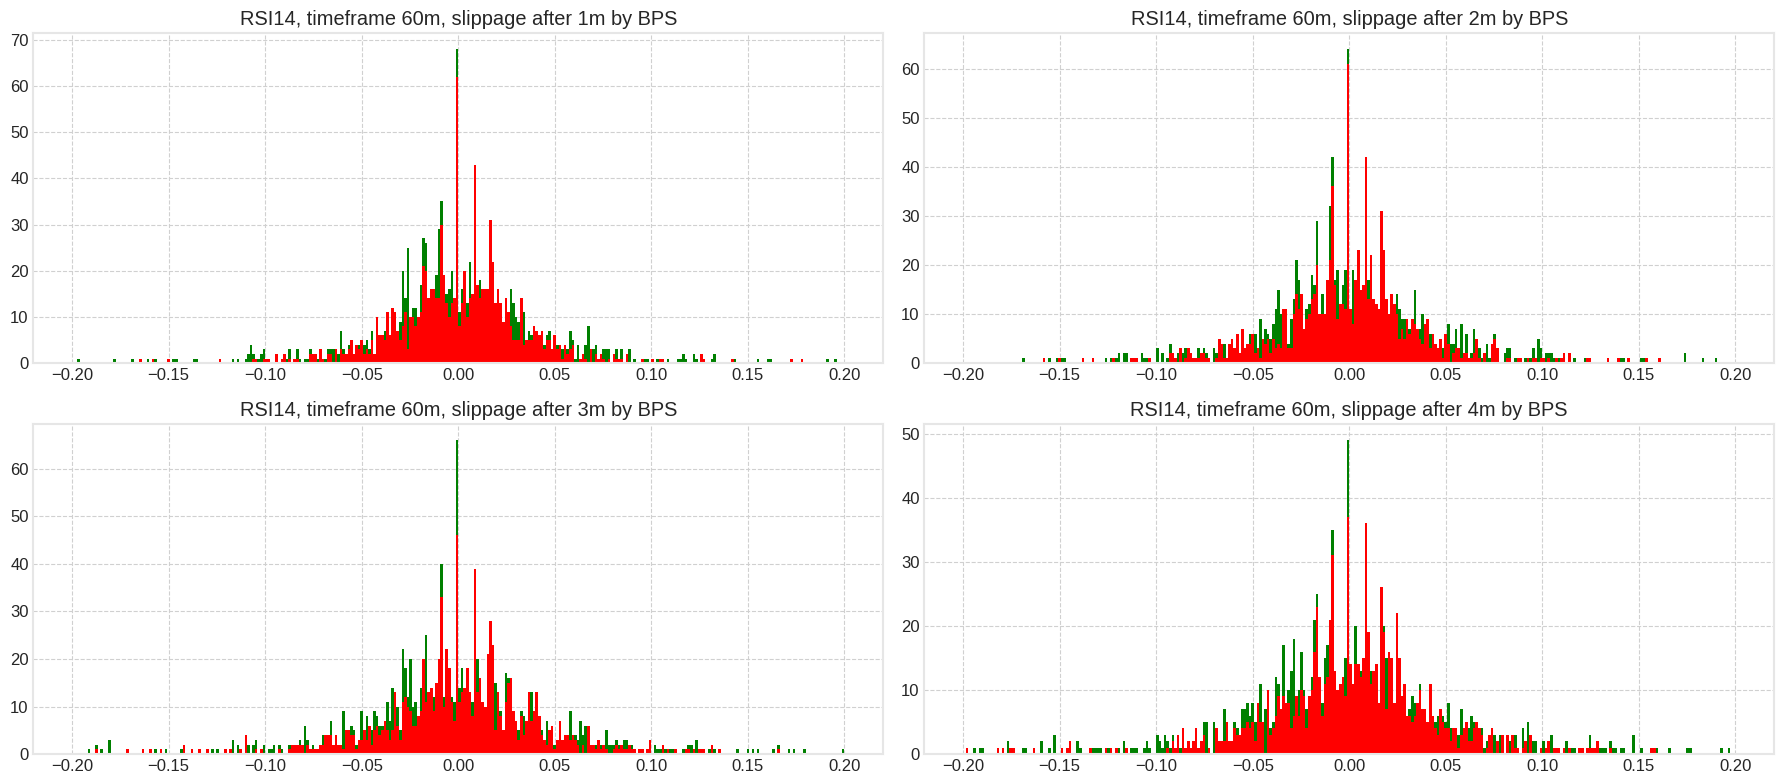

In [18]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-0.2, 0.2)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();

In [19]:
timeframe_by_hours  = 4
timeframe_by_minute = timeframe_by_hours*60

In [20]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2000-01-02 20:00:00+00:00,102.140,102.260,102.120,102.200,104
2000-01-03 00:00:00+00:00,102.200,102.220,101.840,101.930,393
2000-01-03 04:00:00+00:00,101.960,102.100,101.590,101.670,647
2000-01-03 08:00:00+00:00,101.670,101.900,101.630,101.860,1067
2000-01-03 12:00:00+00:00,101.870,101.890,101.390,101.410,1258
...,...,...,...,...,...
2023-08-09 08:00:00+00:00,143.244,143.450,143.216,143.435,10731
2023-08-09 12:00:00+00:00,143.439,143.726,143.240,143.583,19426
2023-08-09 16:00:00+00:00,143.583,143.745,143.405,143.704,7805


mean    : 50.84635200910341
std.dev : 12.68377706842617
sigma lower : 25.5
sigma upper : 76.2


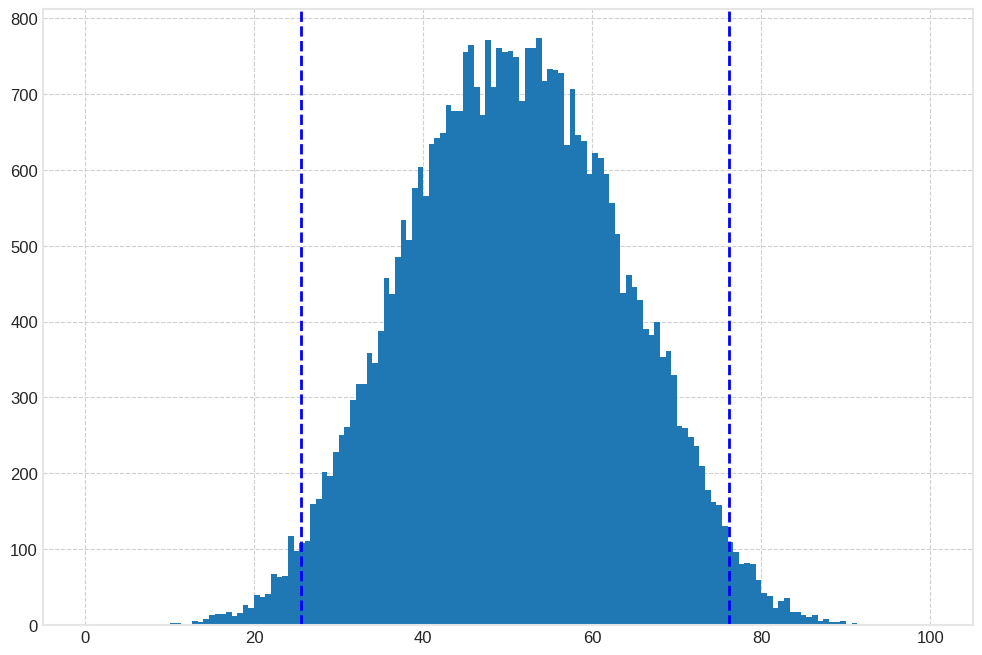

In [21]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [22]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
 1.0    290
-1.0    243
Name: count, dtype: int64

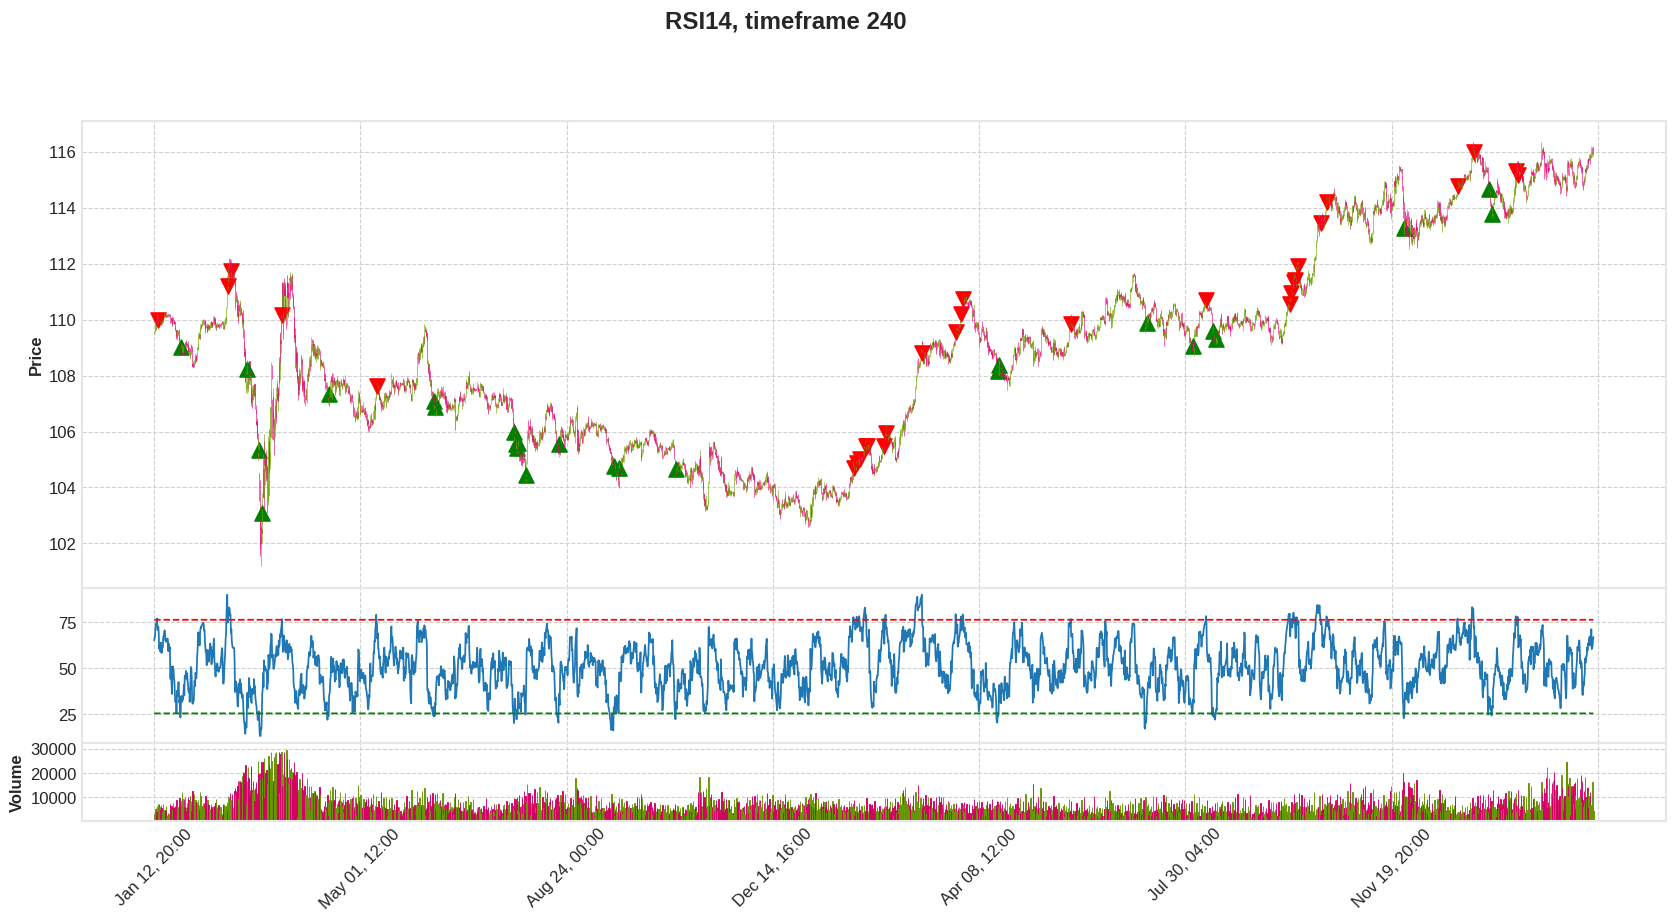

In [24]:
plot_df = df["2020-01-12 10:00:00":"2022-03-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=120, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=120, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [25]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

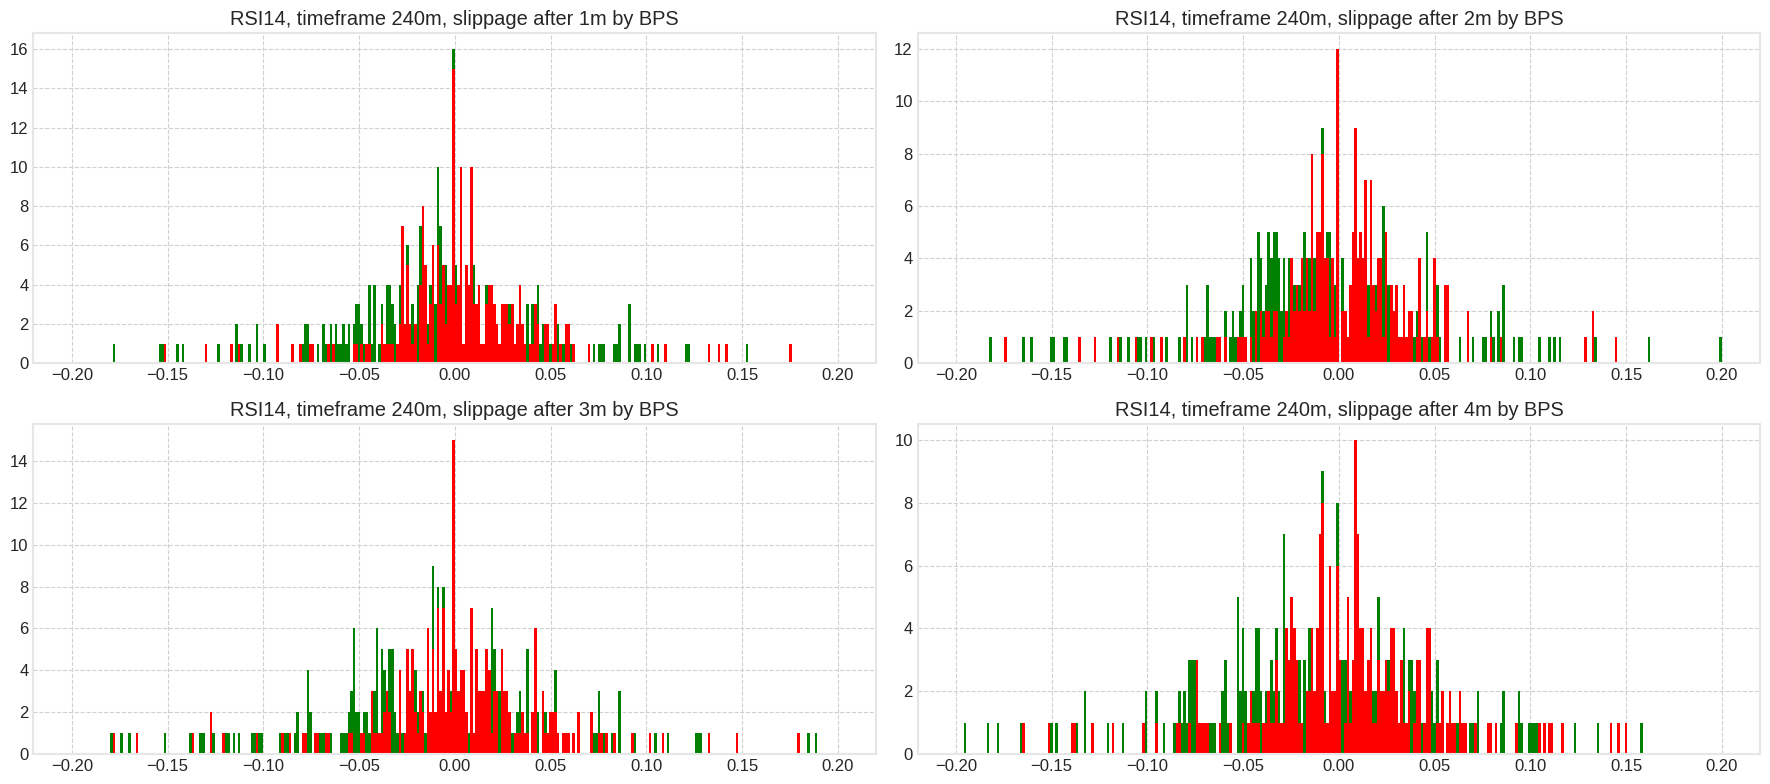

In [26]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-0.2, 0.2)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();

In [27]:
timeframe_by_hours  = 24
timeframe_by_minute = timeframe_by_hours*60

In [28]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2000-01-02 00:00:00+00:00,102.140,102.260,102.120,102.200,104
2000-01-03 00:00:00+00:00,102.200,102.220,101.390,101.710,4593
2000-01-04 00:00:00+00:00,101.720,103.340,101.500,103.270,6713
2000-01-05 00:00:00+00:00,103.250,104.470,102.800,104.040,5916
2000-01-06 00:00:00+00:00,104.020,105.580,104.020,105.220,6666
...,...,...,...,...,...
2023-08-06 00:00:00+00:00,141.656,141.940,141.647,141.869,4296
2023-08-07 00:00:00+00:00,141.869,142.578,141.511,142.535,57207
2023-08-08 00:00:00+00:00,142.535,143.490,142.526,143.258,78894


mean    : 51.051490903579904
std.dev : 12.492631681704948
sigma lower : 26.1
sigma upper : 76.0


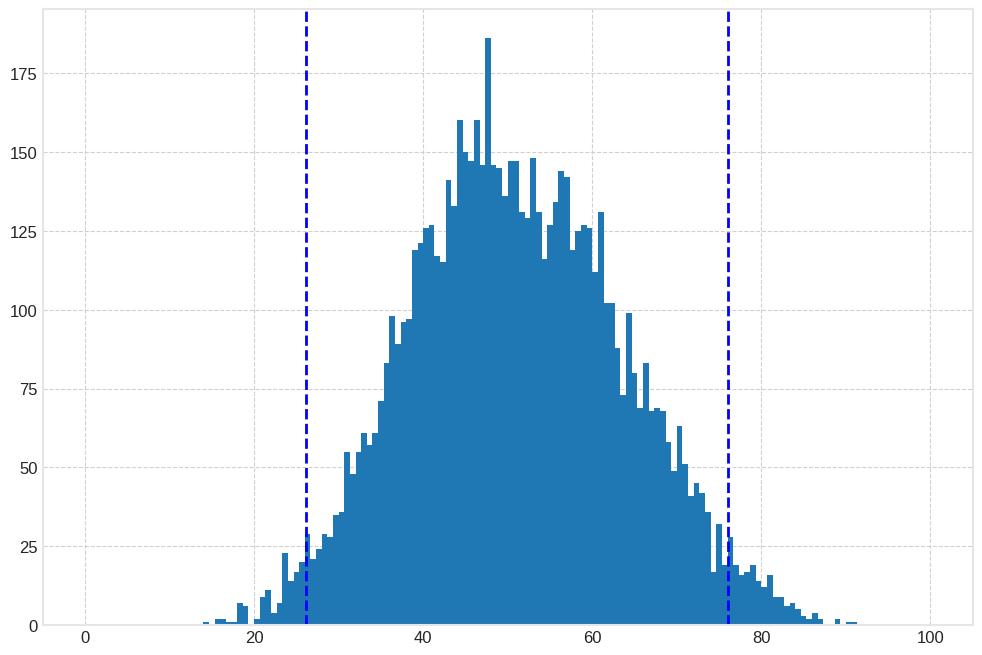

In [29]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [30]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
 1.0    49
-1.0    49
Name: count, dtype: int64

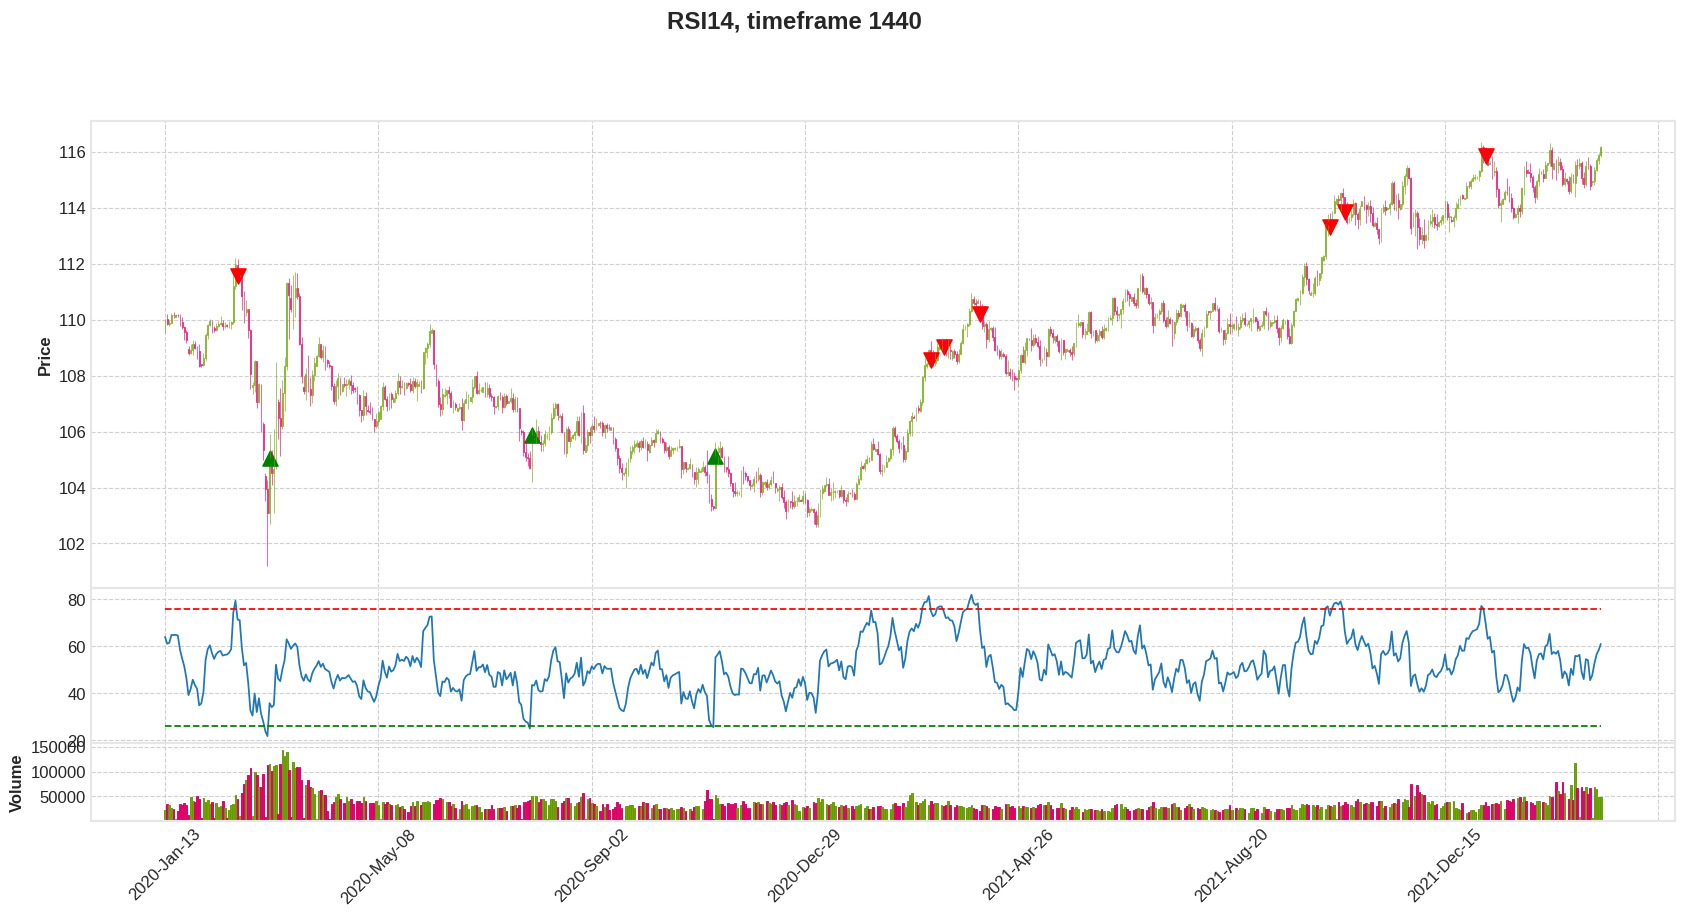

In [31]:
plot_df = df["2020-01-12 10:00:00":"2022-03-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=120, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=120, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [32]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

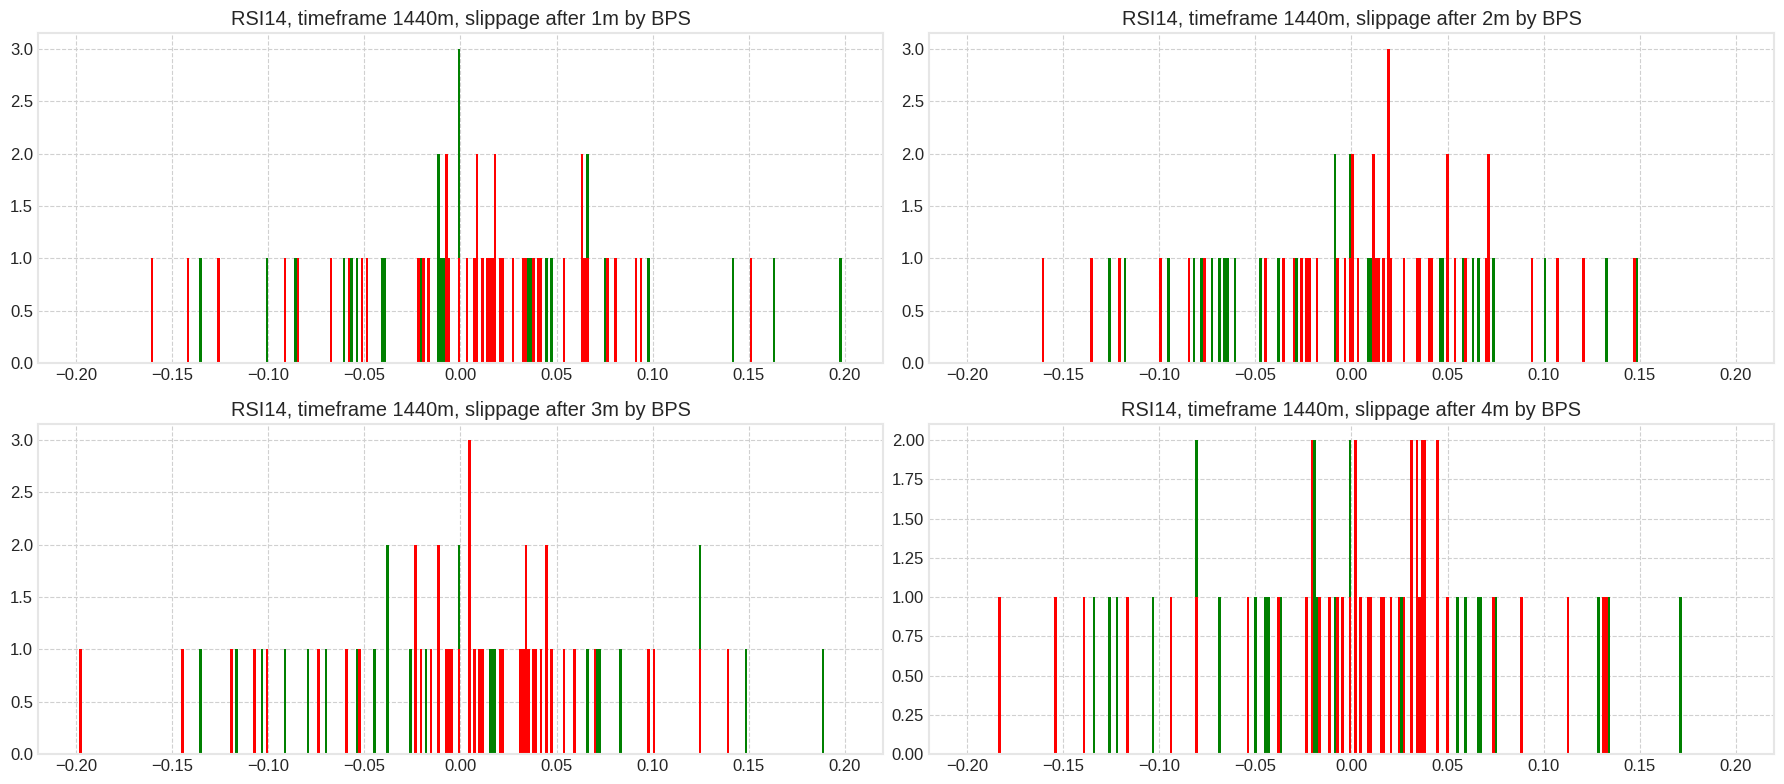

In [33]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-0.2, 0.2)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();